Model I.

LSTM on BTC Close Prices

In [29]:
import pandas as pd

In [30]:
prices=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DATA_1/BTC-USD.csv", engine='python')
prices = prices[['Date', 'Close']]

In [31]:
prices

,Date,Close
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014
...,...,...
3024,2022-12-28,16552.572266
3025,2022-12-29,16642.341797
3026,2022-12-30,16602.585938
3027,2022-12-31,16547.496094


Converting to proper datetypes

In [32]:
prices['Date'] =  pd.to_datetime(prices['Date'], format='%Y-%m-%d')

In [33]:
prices.dtypes

Date     datetime64[ns]
Close           float64
dtype: object

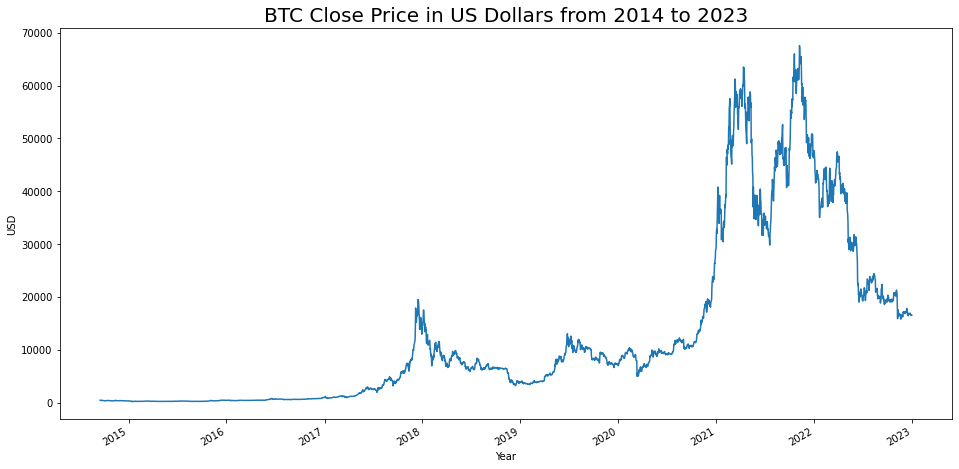

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.title('BTC Close Price in US Dollars from 2014 to 2023', fontsize=20)
#plt.title('Wartość BTC w dolarze amerykańskim w latach 2014 - 2023', fontsize=20)
plt.plot(prices['Date'], prices['Close'])
plt.gcf().autofmt_xdate()
#plt.xlabel('Rok', fontsize=10)
plt.xlabel('Year', fontsize=10)
plt.ylabel('USD', fontsize=10)
plt.show()

In [35]:
split_rows_when=int(round(len(prices["Date"])*(0.8),0))


In [36]:
split_rows_when

2423

Reshaping the values with an additional dimension for the scaler to work.


In [37]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
close_price = prices.Close.values.reshape(-1, 1)
scaled_price = scaler.fit_transform(close_price)

Array reshaped:

In [38]:
print(close_price)

[[  457.334015]
 [  424.440002]
 [  394.79599 ]
 ...
 [16602.585938]
 [16547.496094]
 [16548.261719]]


Removing NaN values from the array (if any):

In [39]:
import numpy as np
scaled_price = scaled_price[~np.isnan(scaled_price)]
scaled_price = scaled_price.reshape(-1, 1)

Array scaled with MinMaxScaler:

In [40]:
print(scaled_price)

[[0.00414359]
 [0.00365546]
 [0.00321557]
 ...
 [0.24372746]
 [0.24290997]
 [0.24292133]]


LSTM Preparation:

Splitting the 1st dim of thearray after split_rows_when, because data cannot be randomized for LSTM neural network models to have high accuracy.

In [41]:
treningowe = scaled_price[0:split_rows_when, :]

In [42]:
treningowe.shape

(2423, 1)

In [43]:
X_train = []
y_train = []

Picking the value of previous days for which the model would take the prices into account when calculating predictions:

In [44]:
prev_days=60

In [45]:
for i in range(prev_days, len(treningowe)):
  X_train.append(treningowe[i-prev_days: i, 0])
  y_train.append(treningowe[i, 0])

  if i <= prev_days:
    print(X_train)
    print(y_train)
    print()


[array([0.00414359, 0.00365546, 0.00321557, 0.00342492, 0.0032753 ,
       0.00332473, 0.0038239 , 0.00363714, 0.00346454, 0.00335845,
       0.00328567, 0.00295417, 0.00292874, 0.00309905, 0.00304965,
       0.00292288, 0.00269198, 0.00223721, 0.00211322, 0.00225521,
       0.00234585, 0.00259445, 0.0027738 , 0.0027224 , 0.00273334,
       0.00297447, 0.00315054, 0.0033057 , 0.00321523, 0.00303393,
       0.00305177, 0.0031658 , 0.00313766, 0.00303822, 0.00309209,
       0.00304287, 0.00267573, 0.00267466, 0.00251033, 0.00262063,
       0.00259518, 0.00266387, 0.00233701, 0.00248116, 0.00237752,
       0.00219096, 0.00219308, 0.00221774, 0.00226134, 0.00239481,
       0.00254029, 0.00243827, 0.00248387, 0.00274766, 0.00280197,
       0.00281341, 0.00364242, 0.00360048, 0.00326041, 0.00293862])]
[0.0031129686991635463]



X_train -> 2363 array with prices for any 60 days from the input dates.

y_train -> 2363 values of last price for those 60 days

In [46]:
len(X_train)

2363

In [47]:
len(y_train)

2363

In [48]:
X_train = np.array(X_train)

y_train=np.array(y_train)

In [49]:
X_train.shape

(2363, 60)

In [50]:
y_train.shape

(2363,)

LSTM network needs the input data to be 3-dimensional - adding a dummy dimension

In [51]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(2363, 60, 1)

Same workflow for test data

Splitting scaled_price array with the number of days threshold

In [52]:
testowe = scaled_price[split_rows_when-prev_days: , :]

In [53]:
X_test = []
y_test = scaled_price[split_rows_when: , :]

#appending same kind of values to X_test list -> 60 days prices
for i in range(prev_days, len(testowe)):
  X_test.append(testowe[i-prev_days : i, 0])

In [54]:
#converting datatype to an array

X_test = np.array(X_test)

In [55]:
#reshaping to a 3-dimensional array for LSTM to work with dummy dimension 1
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

Defining and designing the model

In [56]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM

Setting up the global random seed

In [57]:
tf.random.set_seed(23)

The model will consist of 4 layers:


*   1st LSTM layer that will receive the input data from the sequence of prices for any 60 days and will return sequential data in the output
*   2nd LSTM layer that will receive the 1st output and then return the last output in the output sequence
*   3rd layer - Dense with an output of 25 units and bias set to true
*   4th layer - Dense with an output of only one unit - one predicted Bitcoin price

In [58]:
input1 = (X_train.shape[1], 1)

In [59]:
Imodel = Sequential()
Imodel.add(LSTM(50, return_sequences=True, input_shape=input1))
Imodel.add(LSTM(50, return_sequences=False))
Imodel.add(Dense(25, use_bias=True))
Imodel.add(Dense(1, use_bias=True))

In [74]:
Imodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


Compiling the Ist model.


Optimizing with Adam - stochastic gradient descent (based on adaptive estimation of first-order and second-order moments).

Loss as MSE.

In [60]:
import keras

In [61]:
loss_fn = keras.losses.MeanSquaredError()

In [62]:
Imodel.compile(loss=loss_fn, optimizer='adam')

Preparing a callback for Early Stopping of the model if loss is increasing (monitor parameter as loss).

In [63]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
epochs = Imodel.fit(X_train, y_train, batch_size=1, shuffle=False, epochs=10)

Epoch 1/10
2363/2363 [==============================] - 75s 30ms/step - loss: 0.0017
Epoch 2/10
2363/2363 [==============================] - 69s 29ms/step - loss: 6.8387e-04
Epoch 3/10
2363/2363 [==============================] - 71s 30ms/step - loss: 4.9632e-04
Epoch 4/10
2363/2363 [==============================] - 69s 29ms/step - loss: 4.2155e-04
Epoch 5/10
2363/2363 [==============================] - 68s 29ms/step - loss: 2.4003e-04
Epoch 6/10
2363/2363 [==============================] - 69s 29ms/step - loss: 3.2718e-04
Epoch 7/10
2363/2363 [==============================] - 68s 29ms/step - loss: 2.1518e-04
Epoch 8/10
2363/2363 [==============================] - 67s 29ms/step - loss: 3.3853e-04
Epoch 9/10
2363/2363 [==============================] - 69s 29ms/step - loss: 2.2903e-04
Epoch 10/10
2363/2363 [==============================] - 68s 29ms/step - loss: 2.0023e-04


Making predictions from X_test

In [64]:
pred = Imodel.predict(X_test)

#unscalling the predictions
pred = scaler.inverse_transform(pred)

#number of pred
len(pred)

19/19 [==============================] - 1s 19ms/step


606

Defining the function for calculating the root mean square error of the model

In [65]:
def rmse(prediction,testing):
  return np.sqrt(np.mean(prediction - testing)**2)

RMSE for Imodel

In [66]:
rmse(pred,y_test)

36122.513193061575

RMSE is 36122,5.

Creating a df from dictionary of the epochs for the Ist model

In [72]:
from keras.callbacks import History
plot_of_epochs = pd.DataFrame(epochs.history)

Text(0, 0.5, 'loss')

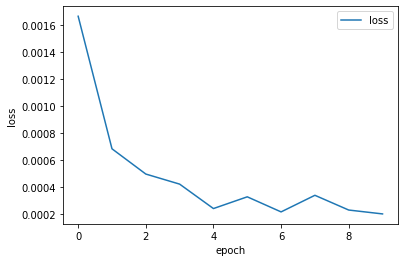

In [73]:
plot_of_epochs.index += 0
plot_of_epochs.plot()
plt.xlabel("epoch")
plt.ylabel("loss")

Best performance of model I is observed in the last epoch (10th), so no need to create it all over again.

Model evaluation

In [77]:
import math

y_test_eval = scaler.inverse_transform(y_test)
#pred is inverted already

array_conc_eval_pred = np.concatenate((y_test_eval,pred),axis=1)

df_pred = pd.DataFrame(data = array_conc_eval_pred, columns=["actual", "predicted"])

df_pred

,actual,predicted
0,56396.515625,57609.953125
1,57356.402344,56344.523438
2,58803.777344,57444.332031
3,58232.316406,58756.574219
4,55859.796875,58160.500000
...,...,...
601,16552.572266,16946.335938
602,16642.341797,16782.958984
603,16602.585938,16844.162109
604,16547.496094,16803.640625


In [79]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

results = Imodel.evaluate(X_test, y_test)

print("mse: %s" % (mean_squared_error(y_test_eval, pred)))
print(results)

19/19 [==============================] - 0s 18ms/step - loss: 5.1095e-04
mse: 2320339.8493948737
0.0005109483026899397


In [83]:
ar_test = np.repeat(1, len(y_test_eval))
ar_pred = np.repeat(2, len(pred))

df_test = pd.DataFrame(data = np.concatenate((y_test_eval,(np.reshape(ar_test, (-1, 1)))),axis=1), columns=["price","act/pred"])
df_pred = pd.DataFrame(data = np.concatenate((pred,(np.reshape(ar_pred, (-1, 1)))),axis=1), columns=["price","act/pred"])

df_both = [df_test, df_pred]
df_3 = pd.concat(df_both, ignore_index=False)

df_3["act/pred"].replace({1: "act", 2: "pred"}, inplace=True)
df_3.head(10)

,price,act/pred
0,56396.515625,act
1,57356.402344,act
2,58803.777344,act
3,58232.316406,act
4,55859.796875,act
5,56704.574219,act
6,49150.535156,act
7,49716.191406,act
8,49880.535156,act
9,46760.187500,act


In [86]:
len(df_3)

1212

Visualization of the predicted and actual BTC prices from **May 07, 2021** to **Dec 31, 2022**

In [90]:
import plotly.express as px
fig = px.line(df_3, x=df_3.index.values, y="price", color='act/pred', title='BTC Price from May 2021 to Jan 2023')
fig.show()